In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
from pathlib import Path
from torch.nn.functional import grid_sample
from deepshape.curves import *

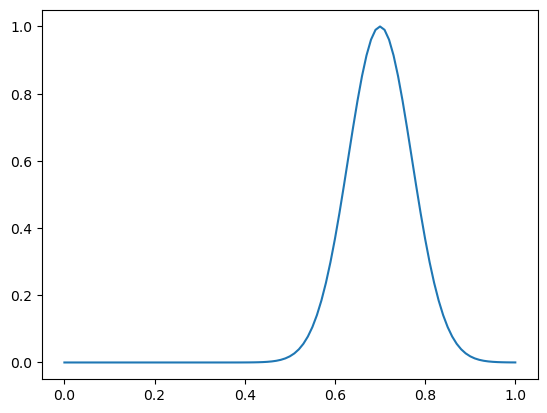

In [4]:
def sqnorm(x):
    return (x**2).sum(dim=-1)

def create_bump_function(amplitude, center, slope):
    return lambda x: amplitude * torch.exp(- slope**2 * sqnorm(x - center)).view(-1, 1)

x = col_linspace(0, 1, 101)
s = col_linspace(0, 1, 5)
f = create_bump_function(1., 0.7, 10)

plt.figure()
plt.plot(x, f(x))
plt.show()

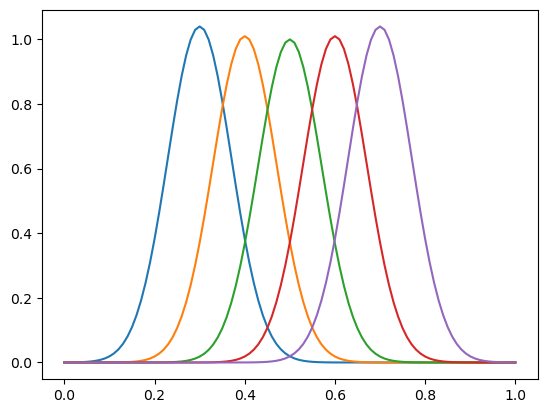

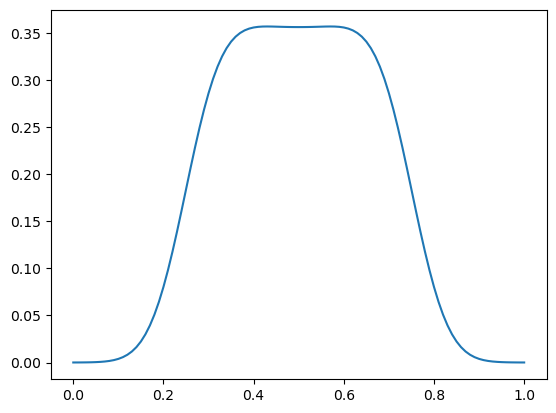

In [189]:
def create_bump_collection(N=5, slope_rand_scale=2.):
    c = np.linspace(0.3, 0.7, N)
    a = 1. * (c - 0.5)**2 + 1. 
    slope = 10 + slope_rand_scale * np.random.randn(N)
    return [
        create_bump_function(ai, ci, si) for ai, ci, si in zip(a, c, slope)
    ]

collection = create_bump_collection(5, 0.)
plt.figure()
for fi in collection:
    plt.plot(x, fi(x))
plt.show()

def linear_mean(function_collection):
    N = len(function_collection)
    def mean(x):
        return torch.hstack([fi(x) for fi in function_collection]).sum(dim=-1, keepdim=True) / N
    return mean

m = linear_mean(collection)
plt.figure()
plt.plot(x, m(x))
plt.show()

In [190]:
def find_functional_center(f, k=512):
    x = col_linspace(0, 1, k)
    return (x * torch.abs(f(x))).sum() / torch.abs(f(x)).sum()


def find_functional_scale(f, k=512):
    x = col_linspace(0, 1, k)
    return torch.abs(f(x)).sum() / k

class FunctionalQmap:
    def __init__(self, f, centering=False, scaling=False):
        if centering:
            c = find_functional_center(f)
            if scaling:
                s = find_functional_scale(f)
                self.f = lambda x: f(x - c + 0.5) / s
            else:
                self.f = lambda x: f(x - c + 0.5)
        else:
            self.f = f
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
#         return torch.sqrt(torch.abs(Df)+1e-8) * f(x)
        return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)

### Test Functional Matching

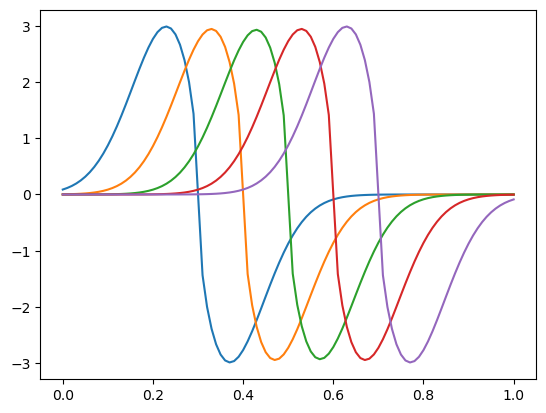


Finished training in 0.25279s


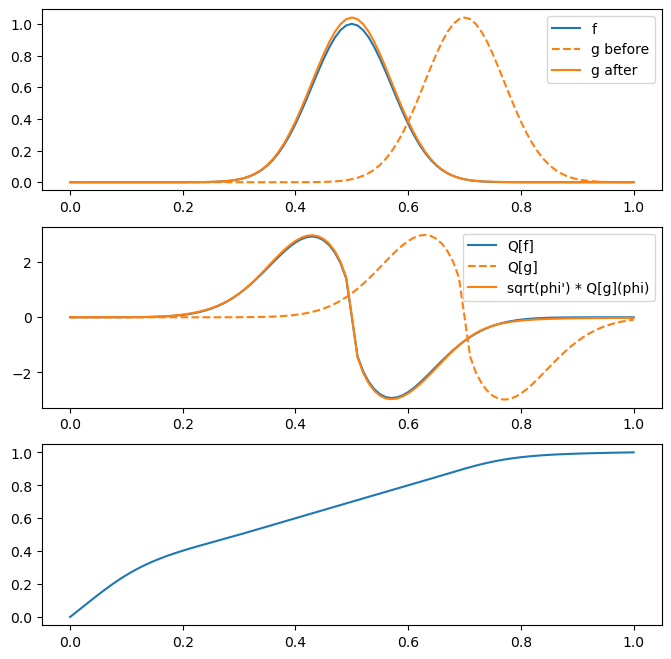

In [196]:
collection = create_bump_collection(5, 0.)
q_collection = [FunctionalQmap(fi, False, False) for fi in collection]

plt.figure()
for fi in q_collection:
    plt.plot(x, fi(x))
# plt.plot(x, FunctionalQmap(m, False, False)(x))
plt.show()


f, g = collection[2], collection[-1]
# f = m
q, r = FunctionalQmap(f, False, False), FunctionalQmap(g, False, False)
loss = CurveDistance(q, r, k=2048)
RN = CurveReparametrizer([
    SineSeries(5) for _ in range(5)
])
opt = torch.optim.LBFGS(RN.parameters(), line_search_fn='strong_wolfe', max_iter=100, max_eval=200)
error = reparametrize(RN, loss, opt, 1, Logger(0))

with torch.no_grad():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
    ax1.plot(x, f(x), label='f')
    ax1.plot(x, g(x), c='C1', ls='--', label='g before')
    ax1.plot(x, g(RN(x)), c='C1', label='g after')
    ax1.legend()
    
    ax2.plot(x, q(x), label='Q[f]')
    ax2.plot(x, r(x), c='C1', ls='--', label='Q[g]')
    ax2.plot(x, torch.sqrt(RN.derivative(x)) * r(RN(x)), c='C1', label="sqrt(phi') * Q[g](phi)")
    ax2.legend()
    plot_diffeomorphism(RN, ax=ax3)
    plt.show()

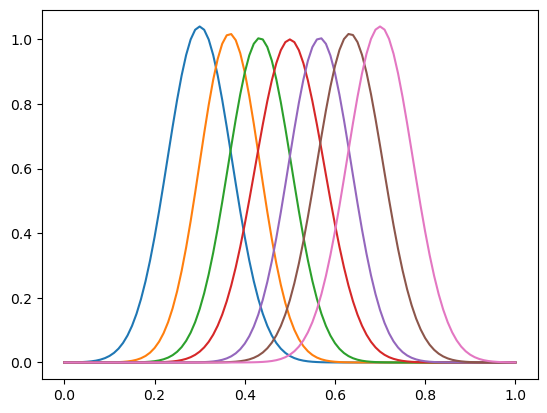


Finished training in 0.40882s

Finished training in 0.16588s

Finished training in 0.16020s

Finished training in 0.00562s

Finished training in 0.14030s

Finished training in 0.13143s

Finished training in 0.49134s


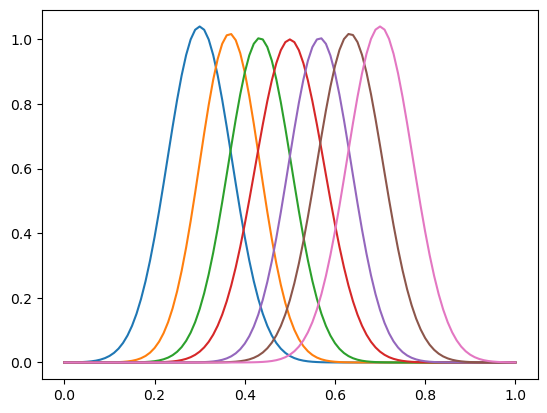

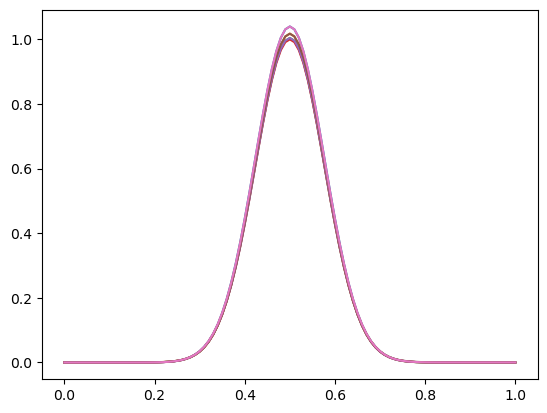

In [201]:
def torch_mse(x1, x2):
    return ((x1 - x2)**2).sum() / x1.shape[0]

def find_best_representative(q_collection):
    N = len(q_collection)
    d = np.inf * np.ones(N)
    x = col_linspace(0, 1, 512)
    m = linear_mean(q_collection)(x)
    for i, qi in enumerate(q_collection):
        d[i] = ((qi(x) - m)**2).sum()
    return np.argmin(d)


def karcher_mean(f_collection):
    q_collection = [FunctionalQmap(fi) for fi in f_collection]
    j = find_best_representative(q_collection)
    mu = q_collection[j]
#     mu = q_collection.pop(j)
    N = len(q_collection)

    RN = [
        CurveReparametrizer([
            SineSeries(5) for _ in range(10)
        ]) for _ in range(N)
    ]
    loss = [
        CurveDistance(mu, r, k=256) for r in q_collection
    ]
    for i in range(N):
        opt = torch.optim.LBFGS(RN[i].parameters(), max_iter=100, line_search_fn='strong_wolfe')
        reparametrize(RN[i], loss[i], opt, 1, Logger(0))
    return j, RN
        

collection = create_bump_collection(7, 1.)
plt.figure()
for fi in collection:
    plt.plot(x, fi(x))
plt.show()

j, RNs = karcher_mean(collection)


plt.figure()
for fi in collection:
    plt.plot(x, fi(x))
plt.show()

with torch.no_grad():
    plt.figure()
    for i, rn in enumerate(RNs):
        plt.plot(x, collection[i](rn(x)), label=f"f{i}")
#     plt.legend()
    plt.show()